In [4]:
!pip install -q --upgrade jcopdl==1.1.10

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Import Data

In [6]:
df = pd.read_csv('/kaggle/input/rnn-dataset/data/daily_min_temp.csv', parse_dates=['Date'], index_col='Date')
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


<Axes: xlabel='Date'>

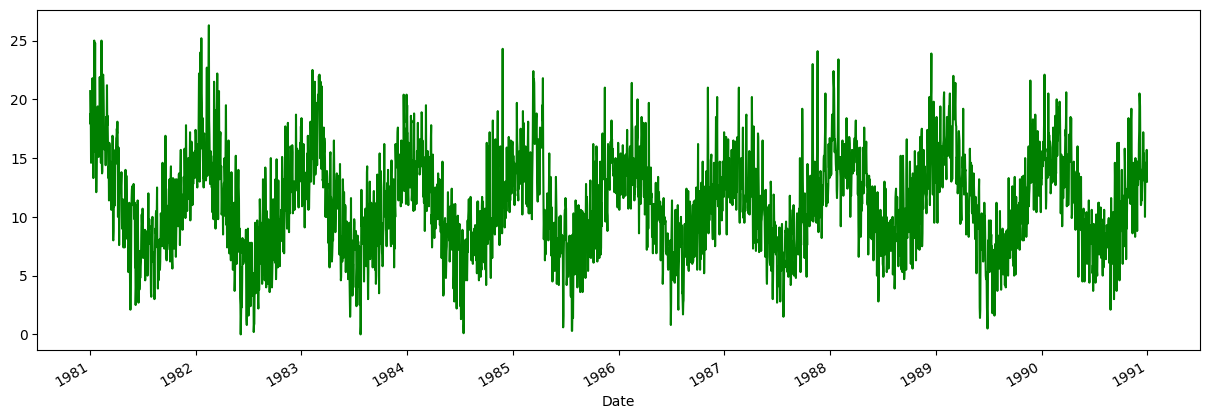

In [7]:
df.Temp.plot(figsize=(15, 5), c='g')

# Dataset Splitting

In [8]:
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape   

((2920, 1), (730, 1))

# Dataset & Dataloader

In [10]:
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [11]:
SEQUENCE_LENGTH = 14
BATCH_SIZE = 32

train_set = TimeSeriesDataset(time_series=ts_train, target_col_name='Temp', seq_len=SEQUENCE_LENGTH, summary=True,)
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2) 

test_set = TimeSeriesDataset(time_series=ts_test, target_col_name='Temp', seq_len=SEQUENCE_LENGTH, summary=True,)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False) 

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



# Arsitektur & Config

In [12]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_size, out_features=output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.gru(x, hidden)
        x = self.fc(x)
        return x, hidden

In [13]:
config = set_config({
    'input_size': train_set.n_feature, 
    'output_size': 1, 
    'hidden_size': 64, 
    'num_layers': 2, 
    'dropout': 0,
    'sequence_length': train_set.n_seq,
    'batch_size': BATCH_SIZE,
})

# Training Preparation -> MCOC

In [14]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean") # kita rata-rata kan loss dari layer LSTM
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config=config, save_every=50, early_stop_patience=5, plot_every=50, outdir='model/lstm')

# Training

In [15]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None) # feedforward input-output ada 2 yaitu ada tambahan hidden dan diawal di nol-kan atau None
        loss = criterion(output, target)
        
        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 127.2314 | Test_cost  = 118.8375 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 101.7576 | Test_cost  = 93.9160 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 79.6356 | Test_cost  = 74.9362 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 64.1691 | Test_cost  = 62.7911 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/op

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 54.2414 | Test_cost  = 54.3804 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 47.0989 | Test_cost  = 47.8522 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 41.4734 | Test_cost  = 42.5255 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 36.8643 | Test_cost  = 38.0713 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 33.0220 | Test_cost  = 34.3171 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 29.8087 | Test_cost  = 31.1546 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 27.1302 | Test_cost  = 28.5014 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 24.9111 | Test_cost  = 26.2883 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 23.0868 | Test_cost  = 24.4543 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 21.5999 | Test_cost  = 22.9452 | 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
self._shutdown_workers()    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can

Train:   0%|          | 0/7 [00:01<?, ?it/s]

self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
if w.is_alive():    
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 20.3991 | Test_cost  = 21.7122 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 19.4384 | Test_cost  = 20.7117 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 18.6773 | Test_cost  = 19.9051 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 18.0799 | Test_cost  = 19.2589 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 17.6155 | Test_cost  = 18.7440 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 17.2578 | Test_cost  = 18.3357 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 16.9845 | Test_cost  = 18.0130 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 16.7773 | Test_cost  = 17.7588 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 16.6213 | Test_cost  = 17.5589 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 16.5045 | Test_cost  = 17.4017 | 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
if w.is_alive():AssertionError: can only test a child process

  File "/op

Train:   0%|          | 0/7 [00:01<?, ?it/s]

AssertionError
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
:     can only test a child processif w.is_alive():

  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 16.4172 | Test_cost  = 17.2780 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 16.3520 | Test_cost  = 17.1804 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 16.3031 | Test_cost  = 17.1031 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 16.2660 | Test_cost  = 17.0416 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 16.2373 | Test_cost  = 16.9921 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 16.2145 | Test_cost  = 16.9519 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 16.1956 | Test_cost  = 16.9186 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 16.1791 | Test_cost  = 16.8904 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 16.1636 | Test_cost  = 16.8656 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 16.1481 | Test_cost  = 16.8426 | 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/op

Train:   0%|          | 0/7 [00:50<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 16.1313 | Test_cost  = 16.8199 | 


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Train:   0%|          | 0/7 [00:30<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 16.1116 | Test_cost  = 16.7953 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 16.0868 | Test_cost  = 16.7655 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 16.0522 | Test_cost  = 16.7234 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 15.9976 | Test_cost  = 16.6507 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 15.8919 | Test_cost  = 16.4939 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 15.6615 | Test_cost  = 16.1831 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 15.2253 | Test_cost  = 15.6609 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 14.5009 | Test_cost  = 14.7801 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 13.4490 | Test_cost  = 13.6030 | 


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0><function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
self._shutdown_workers()
    self._shutdown_workers()  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

    if w.is_alive():  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

    if w.is_alive():  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ig

Train:   0%|          | 0/7 [00:01<?, ?it/s]



Traceback (most recent call last):
AssertionError  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    : can only test a child processself._shutdown_workers()

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 12.5353 | Test_cost  = 12.8879 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 11.9846 | Test_cost  = 12.2176 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 11.4283 | Test_cost  = 11.5716 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 10.9028 | Test_cost  = 10.9435 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 10.4173 | Test_cost  = 10.3769 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 9.9944 | Test_cost  = 9.9007 | 


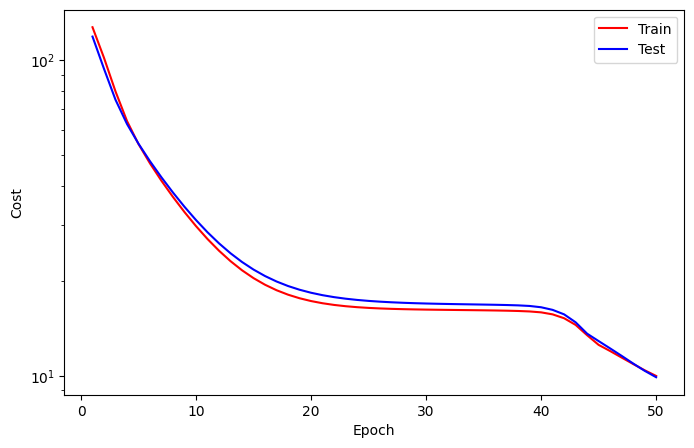

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 9.6397 | Test_cost  = 9.4750 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 9.3240 | Test_cost  = 9.0977 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 9.0406 | Test_cost  = 8.7676 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 8.7919 | Test_cost  = 8.4771 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 8.5773 | Test_cost  = 8.2206 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 8.3922 | Test_cost  = 7.9932 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 8.2312 | Test_cost  = 7.7900 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 8.0886 | Test_cost  = 7.6069 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 7.9595 | Test_cost  = 7.4429 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 7.8421 | Test_cost  = 7.2969 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 7.7364 | Test_cost  = 7.1662 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 7.6414 | Test_cost  = 7.0481 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 7.5554 | Test_cost  = 6.9409 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 7.4768 | Test_cost  = 6.8434 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 7.4049 | Test_cost  = 6.7545 | 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/op

Train:   0%|          | 0/7 [00:00<?, ?it/s]

    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 7.3391 | Test_cost  = 6.6730 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 7.2786 | Test_cost  = 6.5981 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 7.2228 | Test_cost  = 6.5289 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 7.1712 | Test_cost  = 6.4646 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 7.1235 | Test_cost  = 6.4048 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 7.0791 | Test_cost  = 6.3488 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 7.0376 | Test_cost  = 6.2961 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 6.9988 | Test_cost  = 6.2463 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 6.9624 | Test_cost  = 6.1993 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 6.9281 | Test_cost  = 6.1548 | 


Train:   0%|          | 0/7 [00:40<?, ?it/s]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 6.8956 | Test_cost  = 6.1128 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 6.8647 | Test_cost  = 6.0730 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 6.8353 | Test_cost  = 6.0351 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 6.8072 | Test_cost  = 5.9990 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 6.7805 | Test_cost  = 5.9647 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 6.7550 | Test_cost  = 5.9318 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 6.7306 | Test_cost  = 5.9003 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 6.7073 | Test_cost  = 5.8701 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 6.6850 | Test_cost  = 5.8412 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 6.6635 | Test_cost  = 5.8135 | 


Train:   0%|          | 0/7 [01:30<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 6.6429 | Test_cost  = 5.7870 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 6.6230 | Test_cost  = 5.7617 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 6.6039 | Test_cost  = 5.7376 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 6.5856 | Test_cost  = 5.7144 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 6.5680 | Test_cost  = 5.6921 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 6.5511 | Test_cost  = 5.6704 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 6.5349 | Test_cost  = 5.6494 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 6.5193 | Test_cost  = 5.6291 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 6.5043 | Test_cost  = 5.6095 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 6.4898 | Test_cost  = 5.5905 | 


Train:   0%|          | 0/7 [01:30<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 6.4758 | Test_cost  = 5.5722 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 6.4624 | Test_cost  = 5.5544 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 6.4494 | Test_cost  = 5.5372 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 6.4369 | Test_cost  = 5.5206 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 6.4249 | Test_cost  = 5.5044 | 


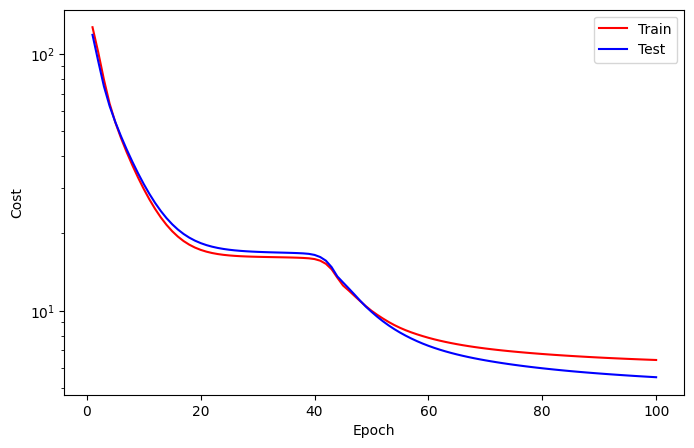

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 6.4133 | Test_cost  = 5.4887 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 6.4020 | Test_cost  = 5.4735 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 6.3912 | Test_cost  = 5.4587 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 6.3807 | Test_cost  = 5.4443 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 6.3705 | Test_cost  = 5.4303 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 6.3607 | Test_cost  = 5.4168 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/op

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 6.3511 | Test_cost  = 5.4036 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 6.3419 | Test_cost  = 5.3908 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 6.3329 | Test_cost  = 5.3783 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 6.3242 | Test_cost  = 5.3662 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 6.3157 | Test_cost  = 5.3544 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 6.3074 | Test_cost  = 5.3430 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 6.2994 | Test_cost  = 5.3319 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 6.2916 | Test_cost  = 5.3210 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   115
Train_cost  = 6.2839 | Test_cost  = 5.3105 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 6.2765 | Test_cost  = 5.3003 | 


Train:   0%|          | 0/7 [01:30<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 6.2692 | Test_cost  = 5.2903 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 6.2621 | Test_cost  = 5.2807 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 6.2552 | Test_cost  = 5.2712 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 6.2484 | Test_cost  = 5.2621 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 6.2418 | Test_cost  = 5.2532 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 6.2353 | Test_cost  = 5.2445 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 6.2289 | Test_cost  = 5.2360 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 6.2227 | Test_cost  = 5.2278 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 6.2166 | Test_cost  = 5.2198 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 6.2106 | Test_cost  = 5.2121 | 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>

Train:   0%|          | 0/7 [00:00<?, ?it/s]


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>



Epoch   127
Train_cost  = 6.2047 | Test_cost  = 5.2045 | 


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():

Train:   0%|          | 0/7 [00:00<?, ?it/s]


  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/data

Test:   0%|          | 0/2 [00:00<?, ?it/s]

    self._shutdown_workers()



Epoch   128
Train_cost  = 6.1989 | Test_cost  = 5.1971 | 


  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'

Train:   0%|          | 0/7 [00:00<?, ?it/s]


AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test:   0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: 


Epoch   129
Train_cost  = 6.1932 | Test_cost  = 5.1900 | 


<function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()

Train:   0%|          | 0/7 [00:00<?, ?it/s]


  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'AssertionError
: can only test a child process
IOStream.flush timed out


Test:   0%|          | 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process



Epoch   130
Train_cost  = 6.1876 | Test_cost  = 5.1830 | 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/op

Train:   0%|          | 0/7 [00:00<?, ?it/s]

    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function 

Test:   0%|          | 0/2 [00:00<?, ?it/s]

IOStream.flush timed out



Epoch   131
Train_cost  = 6.1821 | Test_cost  = 5.1762 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 6.1767 | Test_cost  = 5.1696 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 6.1714 | Test_cost  = 5.1631 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 6.1661 | Test_cost  = 5.1569 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 6.1609 | Test_cost  = 5.1507 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 6.1559 | Test_cost  = 5.1448 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 6.1508 | Test_cost  = 5.1390 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 6.1459 | Test_cost  = 5.1334 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/op

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 6.1410 | Test_cost  = 5.1279 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 6.1362 | Test_cost  = 5.1225 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 6.1315 | Test_cost  = 5.1173 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 6.1268 | Test_cost  = 5.1123 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 6.1222 | Test_cost  = 5.1074 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 6.1177 | Test_cost  = 5.1026 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 6.1132 | Test_cost  = 5.0980 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 6.1087 | Test_cost  = 5.0935 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 6.1043 | Test_cost  = 5.0892 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 6.1000 | Test_cost  = 5.0849 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()    
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'    
AssertionError: can only test a child process
if w.is_alive():Exception ig

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   149
Train_cost  = 6.0956 | Test_cost  = 5.0809 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   150
Train_cost  = 6.0913 | Test_cost  = 5.0769 | 


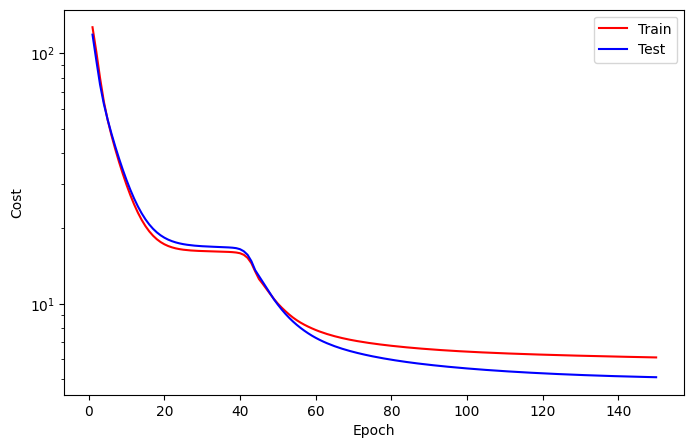

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   151
Train_cost  = 6.0871 | Test_cost  = 5.0731 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   152
Train_cost  = 6.0829 | Test_cost  = 5.0694 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   153
Train_cost  = 6.0787 | Test_cost  = 5.0658 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   154
Train_cost  = 6.0746 | Test_cost  = 5.0624 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   155
Train_cost  = 6.0705 | Test_cost  = 5.0590 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   156
Train_cost  = 6.0664 | Test_cost  = 5.0559 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   157
Train_cost  = 6.0624 | Test_cost  = 5.0528 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   158
Train_cost  = 6.0584 | Test_cost  = 5.0499 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   159
Train_cost  = 6.0544 | Test_cost  = 5.0471 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   160
Train_cost  = 6.0505 | Test_cost  = 5.0444 | 


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/op

Train:   0%|          | 0/7 [00:35<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   161
Train_cost  = 6.0466 | Test_cost  = 5.0418 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   162
Train_cost  = 6.0427 | Test_cost  = 5.0394 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   163
Train_cost  = 6.0389 | Test_cost  = 5.0371 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   164
Train_cost  = 6.0350 | Test_cost  = 5.0348 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   165
Train_cost  = 6.0312 | Test_cost  = 5.0327 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   166
Train_cost  = 6.0275 | Test_cost  = 5.0307 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   167
Train_cost  = 6.0237 | Test_cost  = 5.0288 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   168
Train_cost  = 6.0200 | Test_cost  = 5.0270 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   169
Train_cost  = 6.0163 | Test_cost  = 5.0253 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7c1949a67ac0>self._shutdown_workers()
Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        if w.is_alive():
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/opt/conda/lib/python3.10/multiprocessing/process.

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   170
Train_cost  = 6.0126 | Test_cost  = 5.0236 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   171
Train_cost  = 6.0090 | Test_cost  = 5.0220 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   172
Train_cost  = 6.0054 | Test_cost  = 5.0204 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   173
Train_cost  = 6.0017 | Test_cost  = 5.0190 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   174
Train_cost  = 5.9982 | Test_cost  = 5.0176 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   175
Train_cost  = 5.9946 | Test_cost  = 5.0162 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   176
Train_cost  = 5.9910 | Test_cost  = 5.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   177
Train_cost  = 5.9875 | Test_cost  = 5.0137 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   178
Train_cost  = 5.9840 | Test_cost  = 5.0125 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   179
Train_cost  = 5.9804 | Test_cost  = 5.0113 | 


Train:   0%|          | 0/7 [01:30<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   180
Train_cost  = 5.9769 | Test_cost  = 5.0102 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   181
Train_cost  = 5.9734 | Test_cost  = 5.0090 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   182
Train_cost  = 5.9699 | Test_cost  = 5.0079 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   183
Train_cost  = 5.9663 | Test_cost  = 5.0068 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   184
Train_cost  = 5.9628 | Test_cost  = 5.0058 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   185
Train_cost  = 5.9593 | Test_cost  = 5.0048 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   186
Train_cost  = 5.9557 | Test_cost  = 5.0039 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   187
Train_cost  = 5.9522 | Test_cost  = 5.0032 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   188
Train_cost  = 5.9486 | Test_cost  = 5.0026 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   189
Train_cost  = 5.9450 | Test_cost  = 5.0022 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   190
Train_cost  = 5.9414 | Test_cost  = 5.0020 | 


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Train:   0%|          | 0/7 [00:10<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   191
Train_cost  = 5.9379 | Test_cost  = 5.0018 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   192
Train_cost  = 5.9343 | Test_cost  = 5.0018 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   193
Train_cost  = 5.9307 | Test_cost  = 5.0019 | 
==> EarlyStop patience =  1 | Best test_cost: 5.0018


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   194
Train_cost  = 5.9271 | Test_cost  = 5.0021 | 
==> EarlyStop patience =  2 | Best test_cost: 5.0018


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   195
Train_cost  = 5.9235 | Test_cost  = 5.0024 | 
==> EarlyStop patience =  3 | Best test_cost: 5.0018


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   196
Train_cost  = 5.9199 | Test_cost  = 5.0028 | 
==> EarlyStop patience =  4 | Best test_cost: 5.0018


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   197
Train_cost  = 5.9162 | Test_cost  = 5.0033 | 
==> EarlyStop patience =  5 | Best test_cost: 5.0018
==> Execute Early Stopping at epoch: 197 | Best test_cost: 5.0018
==> Best model is saved at model/lstm


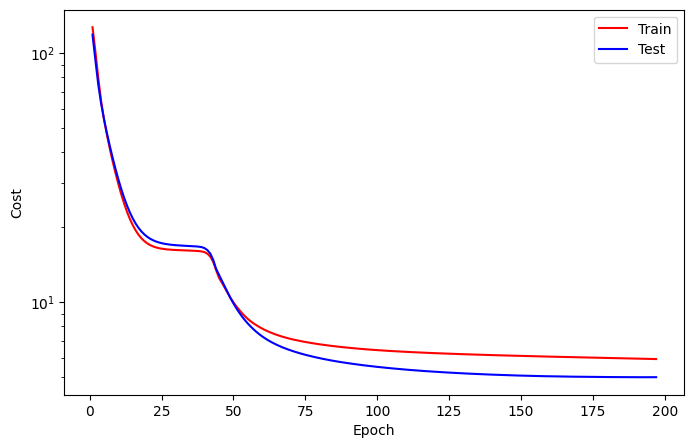

In [16]:
while True:
    train_cost = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)
        
    # Logging and Reporting
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()

#     # Runtime Plotting
    callback.cost_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor='test_cost'): 
        callback.plot_cost()
        break

# Forecast

## Dibawah utility tambahkan (acuhkan saja)

In [17]:
import torch
import matplotlib.pyplot as plt
    
def data4pred(model, dataset, dataloader, device):    
    preds, targets = [], []
    hidden = None
    with torch.no_grad():
        model.eval()
        for inputs, target in dataloader:
            inputs = inputs.to(device)
            
            output, hidden = model(inputs, hidden)
            preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks, targets, 'b-', label="data")
    plt.plot(dataset.target_ticks, preds, 'r-', label="pred")
    plt.legend()    
    
def pred4pred(model, dataset, dataloader, device, n_prior=75, n_forecast=30):
    preds, targets = [], []
    hidden = None    
    end = n_prior + n_forecast    
    with torch.no_grad():
        model.eval()       
        for idx, (inputs, target) in enumerate(dataloader):
            if idx == end:
                break
            elif idx > n_prior:
                inputs[0, 0, 0] = preds[-1]
                
            inputs = inputs.to(device)
            output, hidden = model(inputs, hidden)
            
            if idx > n_prior:
                preds.append(output.flatten().tolist()[-1])
            else:
                preds += output.flatten().tolist()   
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks[:n_prior], targets[:n_prior], 'b-', label="history_data")
    plt.plot(dataset.target_ticks[n_prior:end], targets[n_prior:], 'b-', label="unseen_data", alpha=0.3)
    plt.plot(dataset.target_ticks[:end], preds, 'r-', label="prediction")
    plt.axvline(dataset.target_ticks[n_prior], color='k', linestyle="--", linewidth=1)
    plt.legend()            

In [18]:
train_forecast_set = TimeSeriesDataset(time_series=ts_train, target_col_name='Temp', seq_len=1, summary=True,)
train_forecast_loader = DataLoader(train_forecast_set) 

test_forecast_set = TimeSeriesDataset(time_series=ts_test, target_col_name='Temp', seq_len=1, summary=True,)
test_forecast_loader = DataLoader(test_forecast_set) 

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

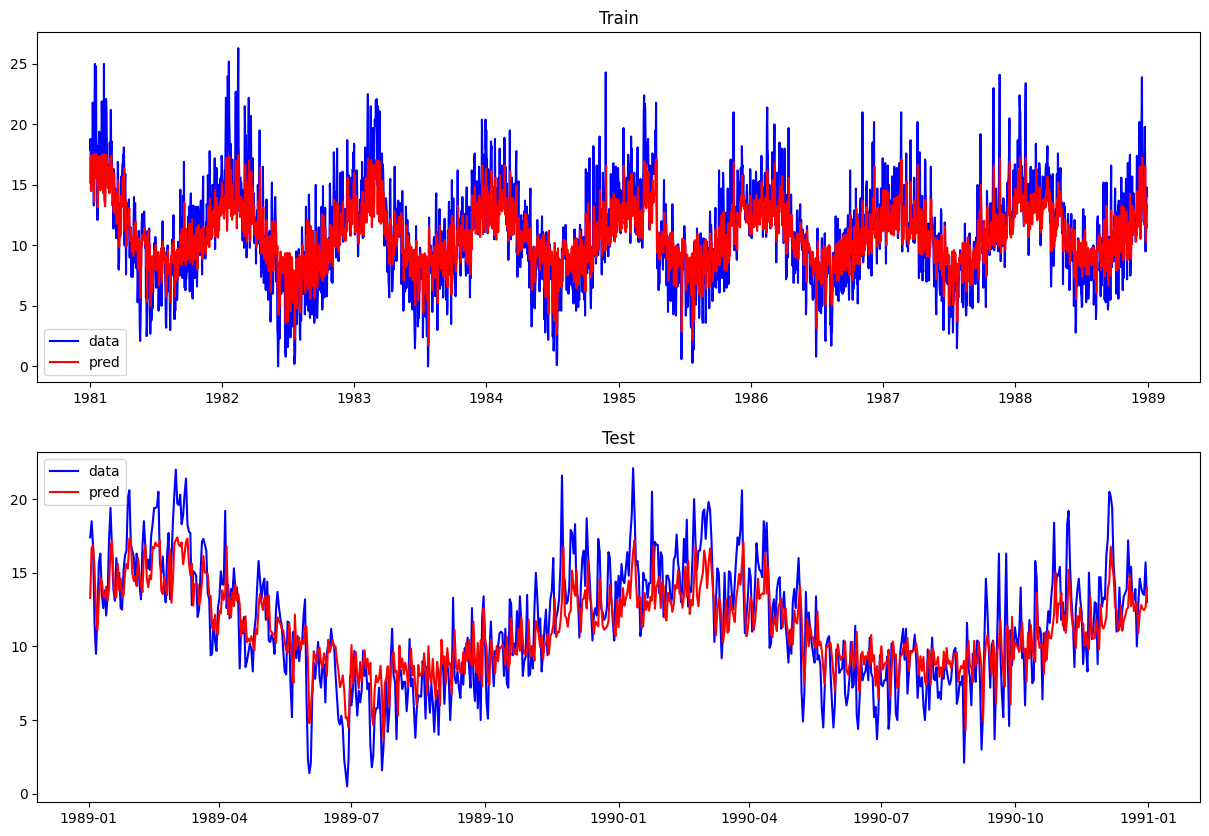

In [19]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, train_forecast_loader, device)
plt.title('Train')

plt.subplot(212)
data4pred(model, test_forecast_set, test_forecast_loader, device)
plt.title('Test')

Text(0.5, 1.0, 'Test')

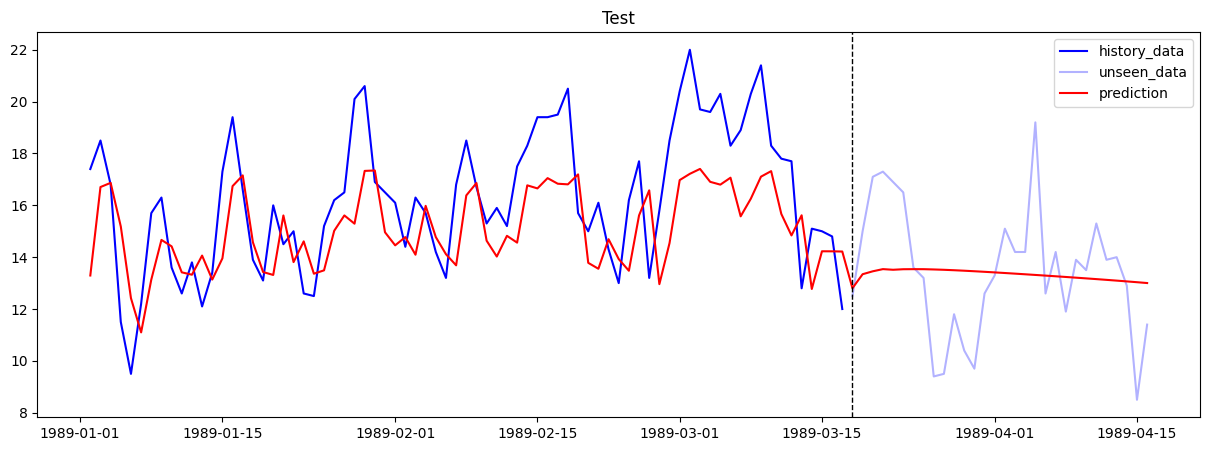

In [20]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, test_forecast_loader, device)
plt.title('Test')

Text(0.5, 1.0, 'Test')

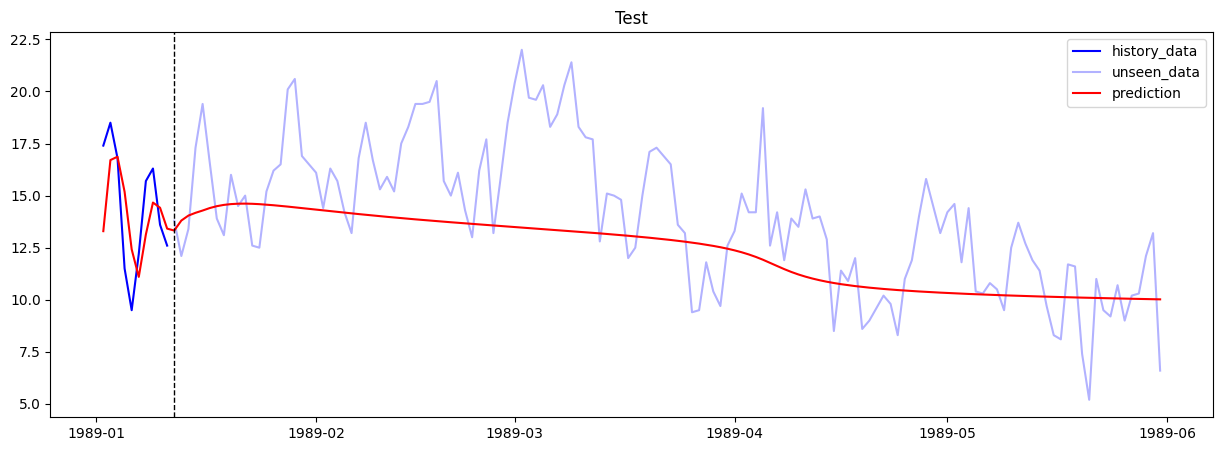

In [21]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, test_forecast_loader, device, n_prior=10, n_forecast=140)
plt.title('Test')